conda create --name applied_project numpy ipykernel jupyter pandas matplotlib ta conda-forge::scikit-learn anaconda::pandas-datareader

# Data Preparation
- Gold Features: Open, High, Low, Volume, Lagged Features, Returns, Price Changes
- Technical Features: MA, EMA, Bollinger Bands, RSI, MACD, ATR
- Macro Features: USD Index DXY, Crude Oil Index, Interest Rates, CPI, S&P 500 Index, VIX, Money Supply
- Categorical Features: Date, Month, Year, Day

In [6]:
import pandas as pd

# Process Gold Features
df = pd.read_csv("Gold Futures Historical Data.csv")
print(df.columns)
print(df.shape)

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'change'], dtype='object')
(4965, 7)


In [7]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y", errors='coerce')

# Make sure no NaT
missing_dates: int = df['date'].isna().sum()
print(missing_dates) # 0

# Sort by date, asc
df = df.sort_values('date').reset_index(drop=True)

# Create year, month and quarter columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter


0


In [8]:
# Fix variable data types - convert to numeric
# Remove final char from volume and change
df['volume'] = df['volume'].str[:-1]
df['change'] = df['change'].str[:-1]

# Remove commas and convert to float
df[["open", "price", "high", "low", "volume", "change"]] = df[["open", "price", "high", "low", "volume", "change"]].replace(',', '', regex=True).astype(float).round(2)
print(df.dtypes)

date       datetime64[ns]
price             float64
open              float64
high              float64
low               float64
volume            float64
change            float64
year                int32
month               int32
quarter             int32
dtype: object


C:\Users\marty\AppData\Local\Temp\ipykernel_22736\3720098556.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(loc=position, column=col_name, value=col_val)


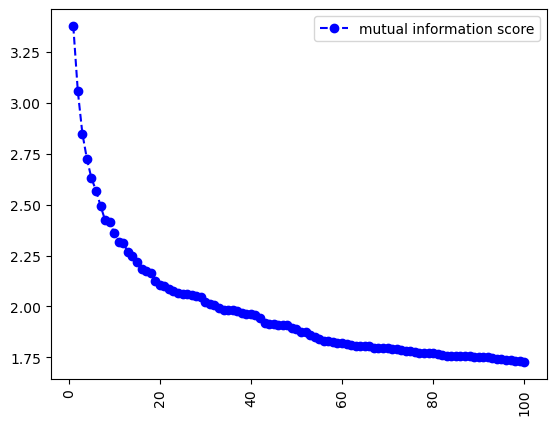

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.feature_selection import mutual_info_regression

# add lags we set in "lag_list" and place them in order to the dataset.
def Add_Lag(data,col,lag_list):
    position = data.columns.tolist().index(col)

    for lag in lag_list:
        col_val = data[col].shift(lag)
        col_name = col+'_lag:'+'{length}'.format(length=lag)
        data.insert(loc=position, column=col_name, value=col_val)
    return data

def mutual_information_lag(Data,col,n_lag,k_best):
    
    #create a dataset by selecting just one column from Gold dataset; a dataset with just one column of {Open,Close,High,Low,Volume} and time as index
    data = pd.DataFrame(Data[col])
    
    #create the dataset that its columns are lags with different shifts
    mic_df = Add_Lag(data,col,[i+1 for i in range(n_lag)])
    mic_ordered = {}
    
    #calculating the mutual information score between lag columns and target column; one of {Open,Close,High,Low,Volume} which selected above
    for i in range(1,n_lag+1):
        
        i_lag = mic_df[mic_df.columns[mic_df.shape[1]-i-1]][i:]
        i_lag_name = mic_df.columns[mic_df.shape[1]-i-1]
        score = mutual_info_regression(np.array(i_lag).reshape(-1, 1), mic_df[col][i:])
        mic_ordered[i_lag_name] = score[0]
    
    #descend sort the lag list by their mutual information score
    sorted_mic = {k: v for k, v in sorted(mic_ordered.items(),reverse=True, key=lambda item: item[1])}
    
    #select the k first lags that have most mutual information scor
    selected_lags = list(sorted_mic.keys())[:k_best]
    
    #create a list of best k lags obtained above
    select_lag_num = []
    for i in selected_lags:
        
        pos = i.find(':')
        select_lag_num.append(int(i[pos+1:]))
        
    select_lag_num_sort = sorted(select_lag_num)
    
    #draw a plot that visualize all lags (not just best k lags) and their mutul information score with the target
    plt.plot([i+1 for i in range(n_lag)], sorted_mic.values(),'--bo', label = "mutual information score")
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()
    
    return select_lag_num_sort,sorted_mic,selected_lags,sorted_mic.values()

best_lags = mutual_information_lag(df,'open',100,10)

In [10]:
# Visually, we can see lags 1 and 2 contain the most information
columns_to_lag = ['price', 'open', 'volume']

for col in columns_to_lag:
    for lag in [1,2]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

df.columns

Index(['date', 'price', 'open', 'high', 'low', 'volume', 'change', 'year',
       'month', 'quarter', 'price_lag_1', 'price_lag_2', 'open_lag_1',
       'open_lag_2', 'volume_lag_1', 'volume_lag_2'],
      dtype='object')

## TA Technical Indicators:

Trend Indicators

Momentum Indicators

Volatility Indicators

In [11]:
# Add Technical Features
import ta

# Initialize ta features (adds automatically NaNs at the beginning)
# 1. Trend Indicators
df['SMA_10'] = ta.trend.SMAIndicator(close=df['price'], window=10).sma_indicator()
df['EMA_10'] = ta.trend.EMAIndicator(close=df['price'], window=10).ema_indicator()
macd = ta.trend.MACD(close=df['price'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

# 2. Momentum Indicators
df['RSI'] = ta.momentum.RSIIndicator(close=df['price'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['price'])
df['Stoch_K'] = stoch.stoch()
df['Stoch_D'] = stoch.stoch_signal()

# 3. Volatility Indicators
boll = ta.volatility.BollingerBands(close=df['price'], window=20, window_dev=2)
df['BB_upper'] = boll.bollinger_hband()
df['BB_lower'] = boll.bollinger_lband()
df['BB_width'] = df['BB_upper'] - df['BB_lower']

df['ATR'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['price']).average_true_range()

df.dropna(inplace=True)  # Drop rows with NaN values after adding indicators

In [12]:
df.head()

,date,price,open,high,low,volume,change,year,month,quarter,...,MACD,MACD_signal,MACD_diff,RSI,Stoch_K,Stoch_D,BB_upper,BB_lower,BB_width,ATR
33,2006-02-21,556.6,557.7,559.5,553.9,42.09,0.36,2006,2,1,...,0.126940,1.941141,-1.814202,51.353616,45.083933,37.250200,581.568850,539.031150,42.537701,11.804005
34,2006-02-22,556.6,556.9,557.7,549.8,45.84,0.00,2006,2,1,...,0.266040,1.606121,-1.340081,51.353616,45.083933,43.485212,581.534892,538.915108,42.619784,11.525147
35,2006-02-23,550.9,556.1,558.4,550.3,42.15,-1.02,2006,2,1,...,-0.082711,1.268355,-1.351066,47.672348,32.587065,40.918310,581.304222,537.985778,43.318444,11.280494
36,2006-02-24,561.2,551.5,562.0,549.6,58.72,1.87,2006,2,1,...,0.466646,1.108013,-0.641367,54.078400,58.208955,45.293318,581.379693,538.040307,43.339386,11.360459
37,2006-02-27,557.0,561.0,561.7,554.8,35.16,-0.75,2006,2,1,...,0.556693,0.997749,-0.441056,51.319486,51.752022,47.516014,581.318995,537.921005,43.397991,11.041854


## Macro Features
- USD Index (Yahoo Finance DXY)
- Crude Oil Prices (Yahoo Finance CL=F)
- Stock Market Index (S&P 500 ^GSPC)  
- Volatility Index (VIX ^VIX)

In [13]:
from pandas_datareader import data as pdr

start_date = '2006-03-01'
end_date = '2025-07-01'

# Define macro tickers for FRED data
fred_series = {
    'dxy': 'DTWEXBGS',         # Trade-Weighted U.S. Dollar Index
    'oil': 'DCOILWTICO',       # Crude Oil Prices (WTI)
    'vix': 'VIXCLS',           # CBOE Volatility Index
    'us10y': 'DGS10',          # 10-Year Treasury Yield
    'cpius': 'CPIAUCSL'        # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
}

macro_df = pd.DataFrame()

# Download Adjusted Close prices
for name, code in fred_series.items():
    series = pdr.DataReader(code, 'fred', start_date, end_date)
    series.rename(columns={code: name}, inplace=True)
    if macro_df.empty:
        macro_df = series
    else:
        macro_df = macro_df.join(series, how='outer')

# Forward-fill CPI values within each month
macro_df['cpius'] = macro_df['cpius'].fillna(method='ffill')

macro_df

C:\Users\marty\AppData\Local\Temp\ipykernel_22736\2920327055.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_df['cpius'] = macro_df['cpius'].fillna(method='ffill')


,dxy,oil,vix,us10y,cpius
DATE,,,,,
2006-03-01,99.8355,62.01,11.54,4.59,199.7
2006-03-02,99.5969,63.36,11.72,4.64,199.7
2006-03-03,99.7024,63.61,11.96,4.68,199.7
2006-03-06,99.9834,62.46,12.74,4.74,199.7
2006-03-07,100.5640,61.51,12.66,4.74,199.7
...,...,...,...,...,...
2025-06-25,120.7333,65.98,16.76,4.29,321.5
2025-06-26,120.0587,66.44,16.59,4.26,321.5
2025-06-27,120.0786,66.66,16.32,4.29,321.5


In [14]:
# Obtain S&P 500 data from spreadsheet
sp500 = pd.read_csv("S&P 500 Historical Data.csv")
sp500.rename(columns={'Date': 'date', 'Price': 'sp500'}, inplace=True)

# Convert date column to datetime
sp500['date'] = pd.to_datetime(sp500['date'])

# Clean numeric values (remove commas, % if present)
sp500['sp500'] = sp500['sp500'].astype(str).str.replace(',', '')
sp500['sp500'] = pd.to_numeric(sp500['sp500'], errors='coerce')

# Keep only date and close price
sp500 = sp500[['date', 'sp500']]
sp500.sort_values('date', inplace=True)

In [15]:
# Merge with your gold DataFrame
df = df.merge(sp500, on='date', how='left')

# Merge macro data with gold dataframe
# Ensure 'date' is datetime type
df['date'] = pd.to_datetime(df['date'])
macro_df = macro_df.reset_index().rename(columns={'DATE': 'date'})

# Merge
df = df.merge(macro_df, on='date', how='left')

# Calculate percentage changes for macro features
macro_cols = ['dxy', 'oil', 'sp500', 'vix', 'us10y']
for col in macro_cols:
    df[f'{col}_pct_change'] = df[col].pct_change(fill_method=None)

# Drop missing rows
df.sort_values('date', inplace=True)
df.dropna(inplace=True)

In [16]:
df.head()

,date,price,open,high,low,volume,change,year,month,quarter,...,dxy,oil,vix,us10y,cpius,dxy_pct_change,oil_pct_change,sp500_pct_change,vix_pct_change,us10y_pct_change
7,2006-03-02,570.4,565.6,570.8,563.7,49.55,0.81,2006,3,1,...,99.5969,63.36,11.72,4.64,199.7,-0.002390,0.021771,-0.001626,0.015598,0.010893
8,2006-03-03,568.0,570.6,572.5,566.2,44.15,-0.42,2006,3,1,...,99.7024,63.61,11.96,4.68,199.7,0.001059,0.003946,-0.001474,0.020478,0.008621
9,2006-03-06,556.8,567.5,570.2,553.5,64.52,-1.97,2006,3,1,...,99.9834,62.46,12.74,4.74,199.7,0.002818,-0.018079,-0.006914,0.065217,0.012821
10,2006-03-07,554.5,556.5,559.8,549.6,72.67,-0.41,2006,3,1,...,100.5640,61.51,12.66,4.74,199.7,0.005807,-0.015210,-0.001877,-0.006279,0.000000
11,2006-03-08,544.3,554.0,555.4,539.5,89.86,-1.84,2006,3,1,...,100.8565,60.06,12.32,4.73,199.7,0.002909,-0.023573,0.002038,-0.026856,-0.002110


## Data Analysis

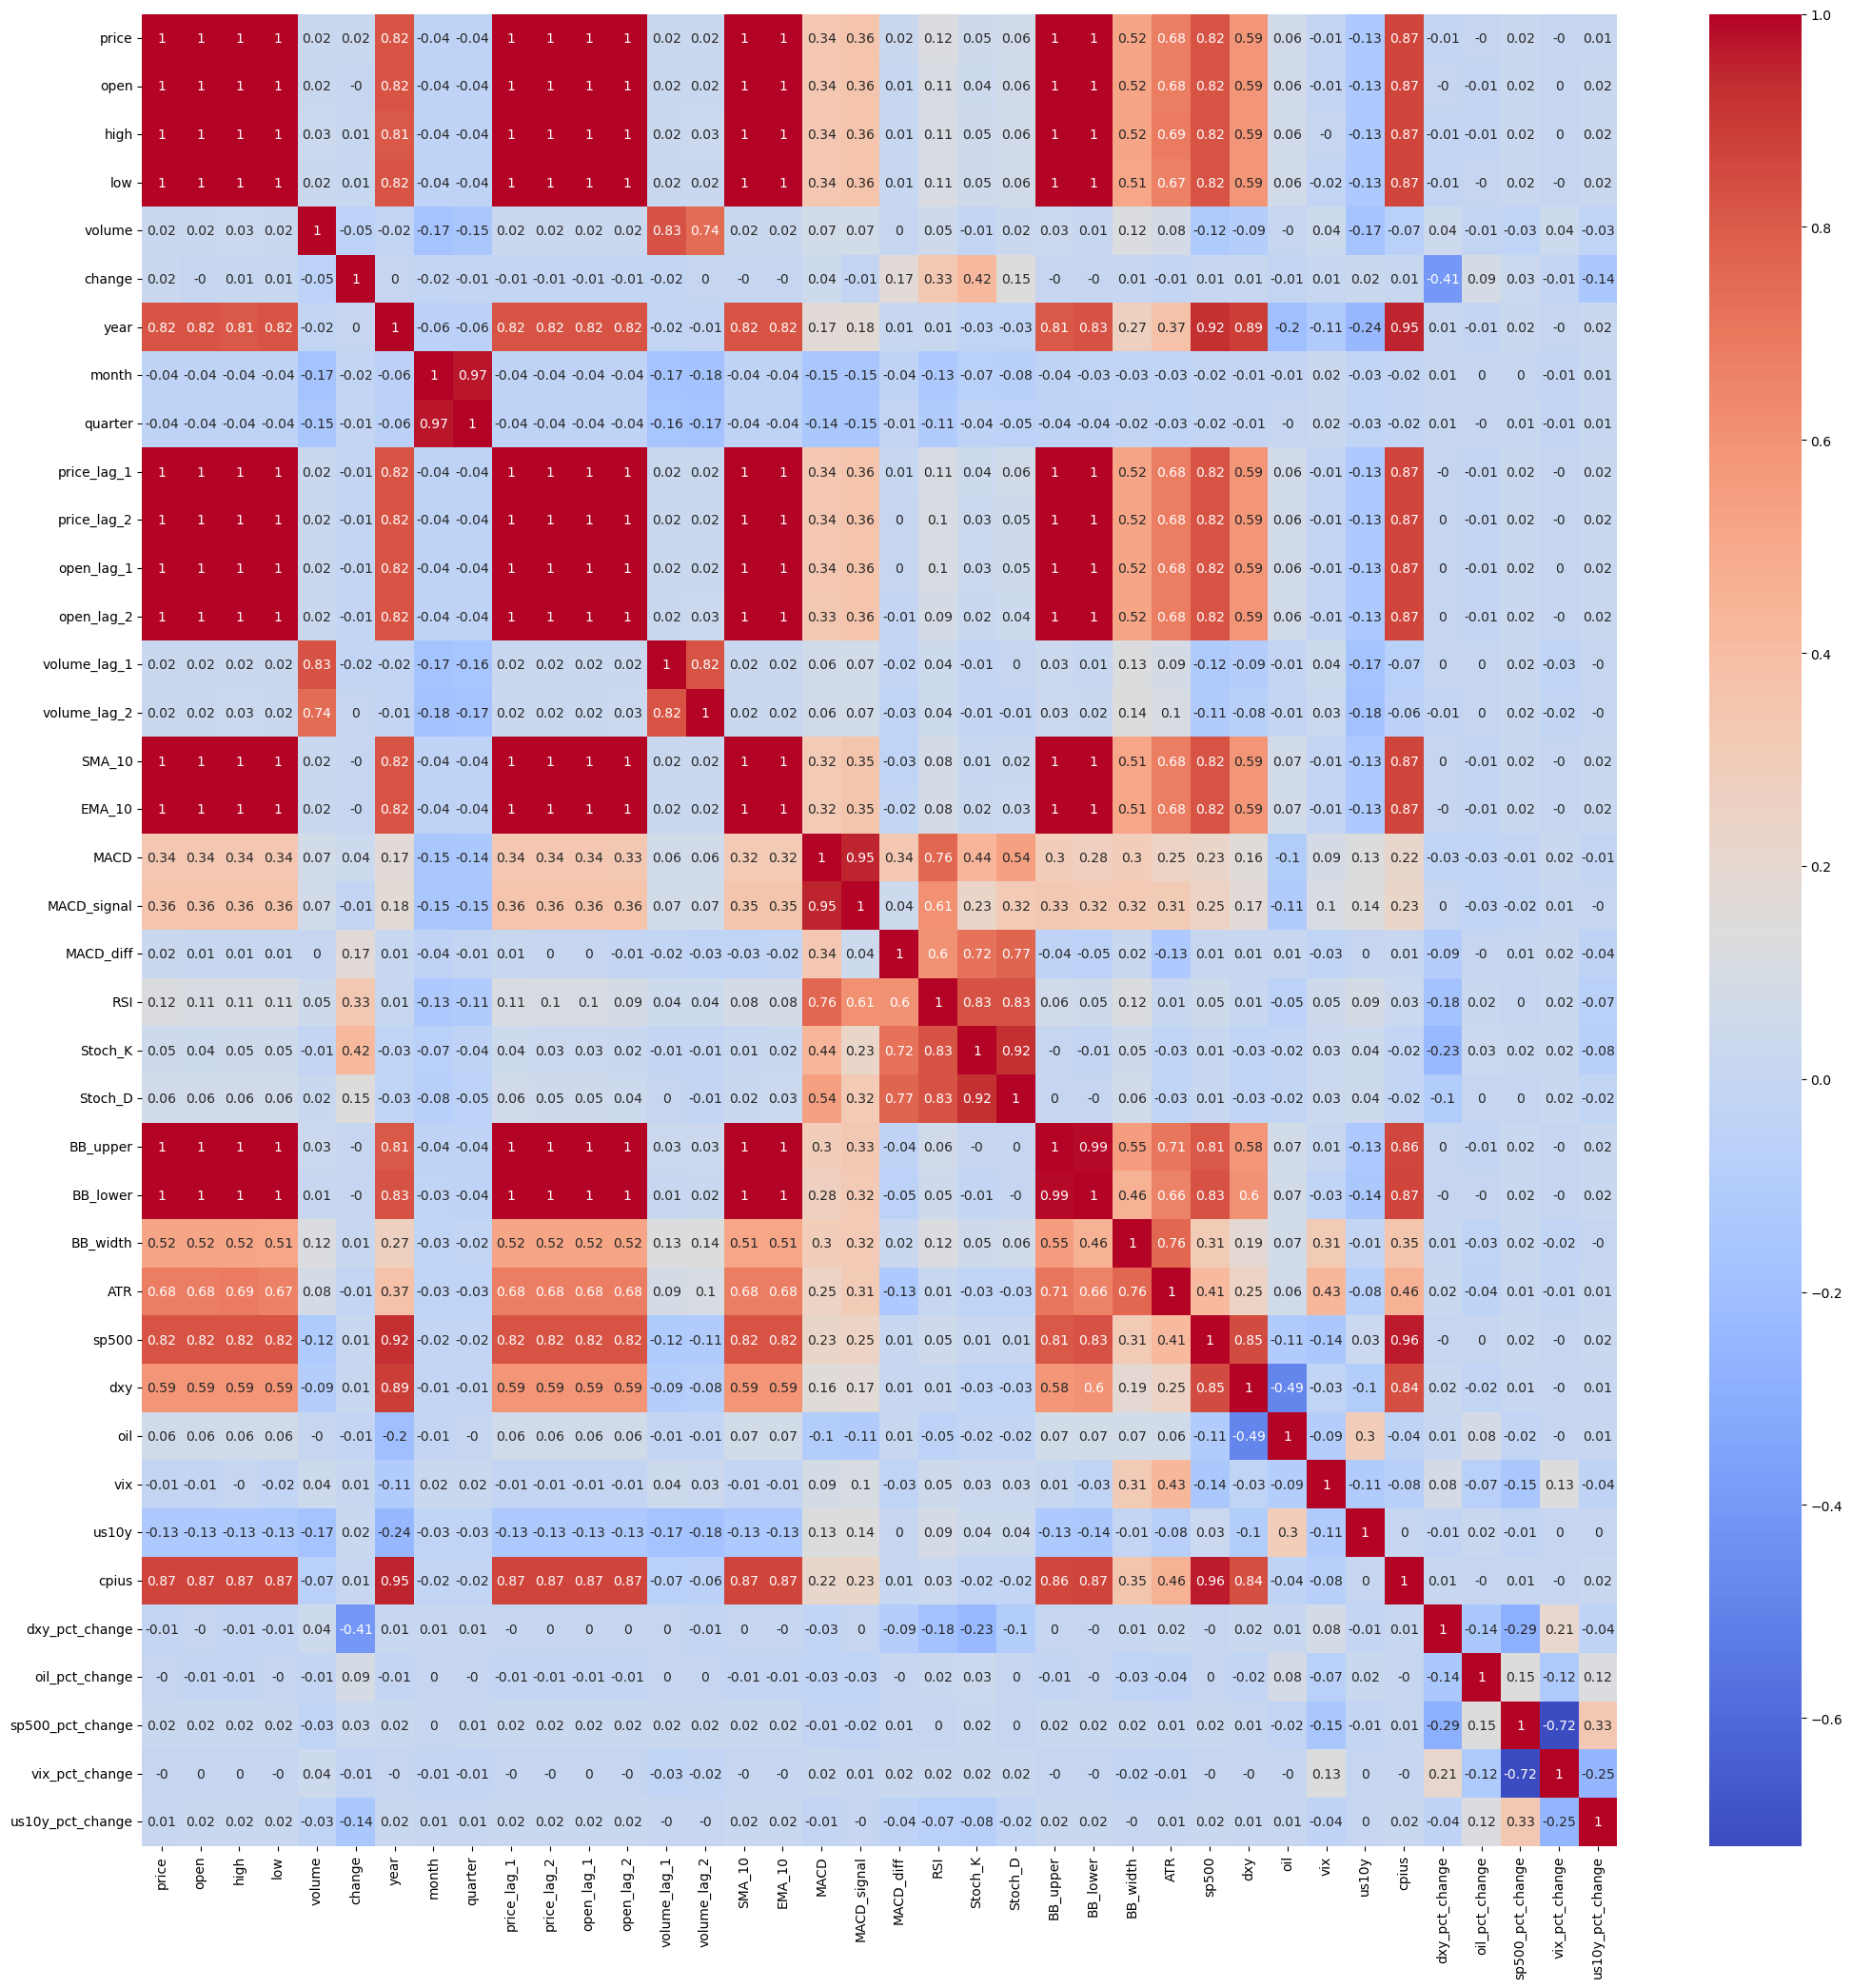

In [17]:
import seaborn as sns

corr = round(df.corr(numeric_only=True),2)
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## Target Variable

<Axes: xlabel='target', ylabel='count'>

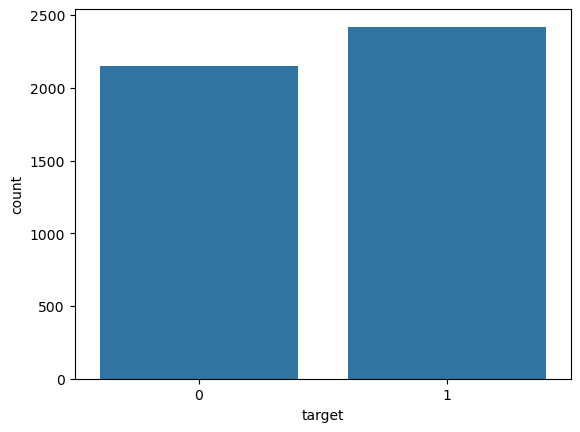

In [18]:
# Creating target variable - next day's binary price direction
df['target'] = (df['price'].shift(-1) > df['price']).astype(int)

# Target Variable Distribution
sns.countplot(x='target', data=df) 

## Split Dataset

In [19]:
from sklearn.model_selection import TimeSeriesSplit

feature_columns = ['date', 'price', 'open', 'high', 'low', 'volume', 'change', 'year',
       'month', 'quarter', 'price_lag_1', 'price_lag_2', 'open_lag_1',
       'open_lag_2', 'volume_lag_1', 'volume_lag_2', 'SMA_10', 'EMA_10',
       'MACD', 'MACD_signal', 'MACD_diff', 'RSI', 'Stoch_K', 'Stoch_D',
       'BB_upper', 'BB_lower', 'BB_width', 'ATR', 'sp500', 'dxy', 'oil', 'vix',
       'us10y', 'cpius', 'dxy_pct_change', 'oil_pct_change',
       'sp500_pct_change', 'vix_pct_change', 'us10y_pct_change']

df.set_index('date', inplace=True)
df.sort_index(inplace=True)
X = df.drop(labels=['target'], axis=1)
y = df['target']

tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


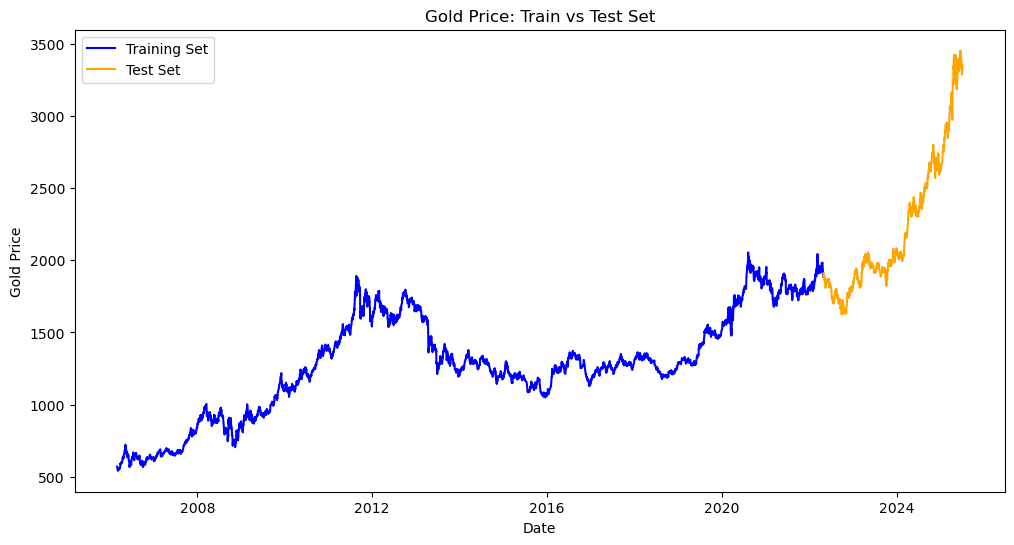

In [20]:
# Get train/test date ranges
train_dates = X_train.index
test_dates = X_test.index

plt.figure(figsize=(12,6))
plt.plot(df.loc[train_dates, 'price'], label='Training Set', color='blue')
plt.plot(df.loc[test_dates, 'price'], label='Test Set', color='orange')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Gold Price: Train vs Test Set')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

# Define the model parameters lists for hyperparameter tuning
param_grids = {
    'log_reg': {'model__C': [0.01, 0.1, 1, 10]},
    'rf': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5, 10]},
    'ada': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.5, 1.0]},
    'xgb': {'model__n_estimators': [200, 400], 'model__max_depth': [3, 5], 'model__learning_rate': [0.01, 0.1]},
    'lgb': {'model__n_estimators': [200, 400], 'model__max_depth': [-1, 5], 'model__learning_rate': [0.01, 0.1]},
    'gbdt': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5], 'model__learning_rate': [0.05, 0.1]}
}

# Fixed Random State
STATE = 42

# Pipeline Creation
pipelines = {
    'log_reg': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'gbdt': Pipeline([
        ('model', GradientBoostingClassifier(random_state=STATE))
    ]),
    'rf': Pipeline([
        ('model', RandomForestClassifier(random_state=STATE))
    ]),
    'xgb': Pipeline([
        ('model', xgb.XGBClassifier(eval_metric='logloss', random_state=STATE))
    ]),
    'lgb': Pipeline([
        ('model', lgb.LGBMClassifier(random_state=STATE, verbose=-1))
    ]),
    'ada': Pipeline([
        ('model', AdaBoostClassifier(random_state=STATE))
    ])
}

In [39]:
tss = TimeSeriesSplit(n_splits=5)
metrics_summary = []
best_models = {}
for name, pipe in pipelines.items():
    print(f"\nRunning GridSearchCV for {name}...")
    grid = GridSearchCV(pipe, param_grids[name], cv=tss, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    # Evaluate on the last fold as a hold-out set
    for train_idx, test_idx in tss.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    metrics_summary.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'ROC-AUC': auc
    })

    print(f"\n{name} Performance on Last Fold:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))


Running GridSearchCV for log_reg...

log_reg Performance on Last Fold:
Accuracy: 0.556 | Precision: 0.580 | Recall: 0.639 | F1: 0.608 | ROC-AUC: 0.574
              precision    recall  f1-score   support

           0       0.52      0.46      0.49       351
           1       0.58      0.64      0.61       410

    accuracy                           0.56       761
   macro avg       0.55      0.55      0.55       761
weighted avg       0.55      0.56      0.55       761


Running GridSearchCV for gbdt...


KeyError: 'gbdt'